## Import Library

In [81]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

In [82]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        7500 non-null   object 
 1   Exercise_Duration         7500 non-null   float64
 2   Body_Temperature(F)       7500 non-null   float64
 3   BPM                       7500 non-null   float64
 4   Height(Feet)              7500 non-null   float64
 5   Height(Remainder_Inches)  7500 non-null   float64
 6   Weight(lb)                7500 non-null   float64
 7   Weight_Status             7500 non-null   object 
 8   Gender                    7500 non-null   object 
 9   Age                       7500 non-null   int64  
 10  Calories_Burned           7500 non-null   float64
dtypes: float64(7), int64(1), object(3)
memory usage: 644.7+ KB


## Preprocessing

In [84]:
le_wei = LabelEncoder()
train_df['Weight_Status'] = le_wei.fit_transform(train_df['Weight_Status'])
test_df['Weight_Status'] = le_wei.transform(test_df['Weight_Status'])
le_gen = LabelEncoder()
train_df['Gender'] = le_gen.fit_transform(train_df['Gender'])
test_df['Gender'] = le_gen.transform(test_df['Gender'])

## Visualization

<ipython-input-5-6c3475b36d78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot = True)


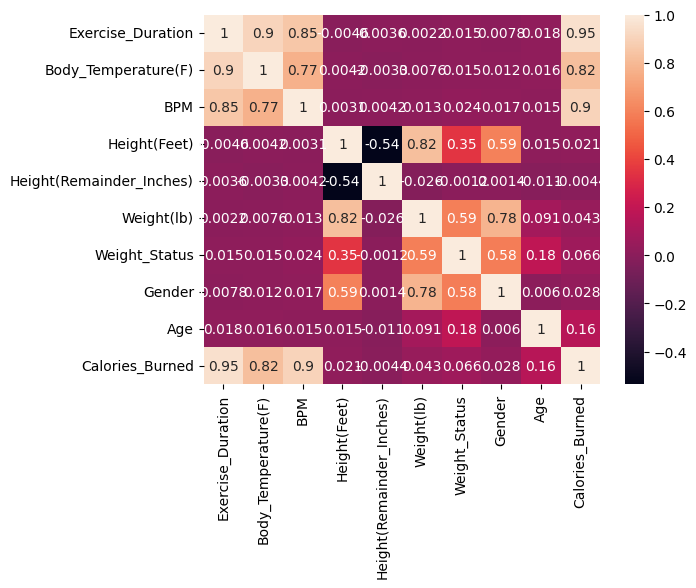

In [5]:
sns.heatmap(train_df.corr(), annot = True)
plt.show()

## Feature Engineering

In [85]:
train_df['Height_Full'] = train_df['Height(Feet)'] * 12 + train_df['Height(Remainder_Inches)']
test_df['Height_Full'] = test_df['Height(Feet)'] * 12 + test_df['Height(Remainder_Inches)']
train_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)
test_df.drop(columns = ['Height(Feet)', 'Height(Remainder_Inches)','ID'], inplace = True)

## MinMaxScaler

In [86]:
mm_list =[]

for idx,i in enumerate(train_df.columns):
  if i == 'Calories_Burned'  or i == 'Gender' or i == 'Weight_Status':
    continue
  mm = MinMaxScaler()
  fitted = mm.fit(train_df[i].values.reshape(-1,1))
  result = mm.transform(train_df[i].values.reshape(-1,1))
  train_df[i] = result.reshape(-1)
  mm_list.append(mm)
idx = 0
for i in test_df.columns:
  if i == 'Gender' or i == 'Weight_Status':
    continue
  result = mm_list[idx].transform(test_df[i].values.reshape(-1,1))
  test_df[i] = result.reshape(-1)
  idx +=1

## onehot

In [87]:
one_hot = OneHotEncoder(sparse = False)
train_wei_one_hot = pd.DataFrame(one_hot.fit_transform(train_df['Weight_Status'].values.reshape(-1,1)), columns = le_wei.inverse_transform([0,1,2]))
test_wei_one_hot = pd.DataFrame(one_hot.transform(test_df['Weight_Status'].values.reshape(-1,1)), columns = le_wei.inverse_transform([0,1,2]))
one_hot = OneHotEncoder(sparse = False)
train_gen_one_hot = pd.DataFrame(one_hot.fit_transform(train_df['Gender'].values.reshape(-1,1)), columns = le_gen.inverse_transform([0,1]))
test_gen_one_hot = pd.DataFrame(one_hot.transform(test_df['Gender'].values.reshape(-1,1)), columns = le_gen.inverse_transform([0,1]))

train_df = pd.concat([train_df, train_wei_one_hot,train_gen_one_hot],axis = 1)
test_df = pd.concat([test_df, test_wei_one_hot,test_gen_one_hot],axis = 1)

train_df.drop(columns = ['Weight_Status', 'Gender'], inplace = True)
test_df.drop(columns = ['Weight_Status', 'Gender'], inplace = True)

## figure

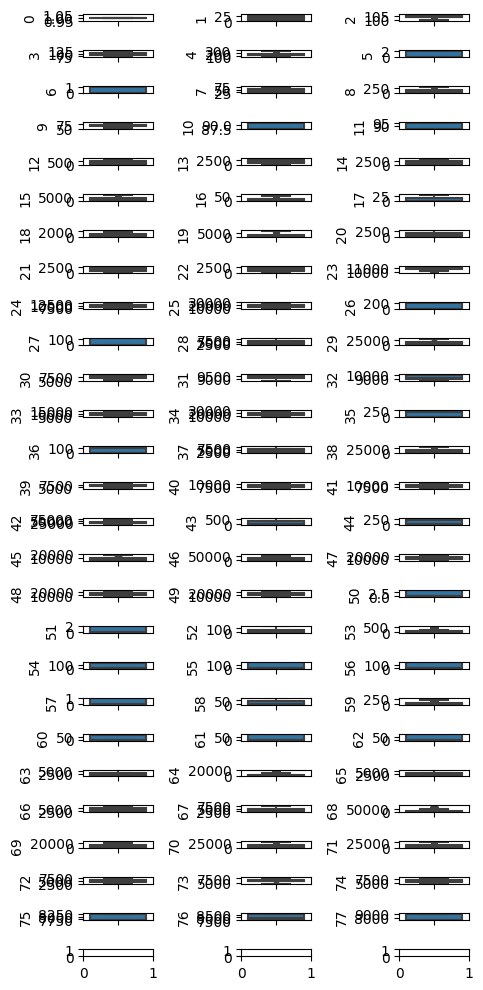

In [ ]:
fig, axes = plt.subplots(len(train_df.columns) // 3 + 1,3, figsize = (5,10))

for idx, col in enumerate(train_df.columns):
  sns.boxplot(y = train_df[col], ax = axes[idx//3][idx % 3])
plt.tight_layout()
plt.show()

In [ ]:
# body temperature은 log transformation
# bpm, height_full, weight(lb) 이상치 확인

""" IQR 처리 """
outlier_column = ['BPM','Weight(lb)','Calories_Burned']
for i in outlier_column:
  Q1 = train_df[i].quantile(0.25)
  Q3 = train_df[i].quantile(0.75)

  IQR = Q3 - Q1
  MIN = Q1 - 1.5 * IQR
  MAX = Q3 + 1.5 * IQR
  target = train_df[(train_df[i] < MIN) | (train_df[i] > MAX)]
  train_df.drop(target.index, inplace = True)
  print(f'{len(target.index)} data is outlier')
print(f'Delete the data...')

1 data is outlier
11 data is outlier
3 data is outlier
2 data is outlier
Delete the data...


## Poly features

In [88]:
poly = PolynomialFeatures(degree = 2)
poly_columns = ['Exercise_Duration','BPM','Body_Temperature(F)']
train_poly = pd.DataFrame(poly.fit_transform(train_df[poly_columns]))
test_poly = pd.DataFrame(poly.fit_transform(test_df[poly_columns]))

train_df[train_poly.columns] = train_poly
test_df[test_poly.columns] = test_poly

train_df.drop(columns = poly_columns, inplace = True)
test_df.drop(columns = poly_columns, inplace = True)

## predict

In [89]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label = 'Calories_Burned', eval_metric = 'rmse',problem_type = 'regression' ).fit(train_data = train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20230418_093050/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230418_093050/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Dec 10 16:00:40 UTC 2022
Train Data Rows:    7500
Train Data Columns: 18
Label Column: Calories_Burned
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10777.65 MB
	Train Data (Original)  Memory Usage: 1.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 5 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...


[1000]	valid_set's rmse: 1.34822
[2000]	valid_set's rmse: 1.22625
[3000]	valid_set's rmse: 1.17813
[4000]	valid_set's rmse: 1.15092
[5000]	valid_set's rmse: 1.12943
[6000]	valid_set's rmse: 1.11205
[7000]	valid_set's rmse: 1.10071
[8000]	valid_set's rmse: 1.0931
[9000]	valid_set's rmse: 1.08576
[10000]	valid_set's rmse: 1.07785


	-1.0778	 = Validation score   (-root_mean_squared_error)
	10.21s	 = Training   runtime
	1.03s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 1.42469
[2000]	valid_set's rmse: 1.40013
[3000]	valid_set's rmse: 1.37918
[4000]	valid_set's rmse: 1.36959
[5000]	valid_set's rmse: 1.36604
[6000]	valid_set's rmse: 1.36554
[7000]	valid_set's rmse: 1.36566


	-1.3649	 = Validation score   (-root_mean_squared_error)
	9.78s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2.836	 = Validation score   (-root_mean_squared_error)
	8.13s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: CatBoost ...
	-0.7087	 = Validation score   (-root_mean_squared_error)
	91.05s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2.7457	 = Validation score   (-root_mean_squared_error)
	3.22s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-1.2186	 = Validation score   (-root_mean_squared_error)
	9.03s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-1.3438	 = Validation score   (-root_mean_squared_error)
	9.82s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-2.2655	 = Validation score   (-root_mean_squared_error)
	11.01s	 = Training   runtime
	0.01s	 = Validation run

[1000]	valid_set's rmse: 1.73955
[2000]	valid_set's rmse: 1.72925
[3000]	valid_set's rmse: 1.72827
[4000]	valid_set's rmse: 1.72791
[5000]	valid_set's rmse: 1.72782
[6000]	valid_set's rmse: 1.72781
[7000]	valid_set's rmse: 1.72779
[8000]	valid_set's rmse: 1.72779
[9000]	valid_set's rmse: 1.72779


	-1.7278	 = Validation score   (-root_mean_squared_error)
	30.74s	 = Training   runtime
	1.48s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.6305	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 198.58s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230418_093050/")


In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.547112       1.913928  154.721749                0.000467           0.330408            2       True         12
1              CatBoost  -0.612067       0.009162   91.705461                0.009162          91.705461            1       True          6
2            LightGBMXT  -0.963873       1.260267   26.036932                1.260267          26.036932            1       True          3
3       NeuralNetFastAI  -1.119805       0.019352   10.089353                0.019352          10.089353            1       True          8
4               XGBoost  -1.517231       0.618047   15.624408                0.618047          15.624408            1       True          9
5              LightGBM  -1.583890       0.117982    2.080513                0.117982           2.

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -12.365811018036608,
  'KNeighborsDist': -11.832849318664278,
  'LightGBMXT': -0.9638725289374104,
  'LightGBM': -1.5838899420079928,
  'RandomForestMSE': -3.060781603113513,
  'CatBoost': -0.6120667661215365,
  'ExtraTreesMSE': -2.944931573991949,
  'NeuralNetFastAI': -1.1198047749095943,
  'XGBoost': -1.5172310306064498,
  'NeuralNetTorch': -1.988546305235349,
  'LightGBMLarge': -1.994219983685126,
  'WeightedEnsemble_L2': -0.547112181965363},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': 'Aut

In [ ]:
# male_cnt = 0 
# female_cnt = 0
# test_df['Calories_Buned'] = [0.1 for i in range(len(test_df))]
# for idx in range(len(test_df)):
#   if test_df.loc[idx,'Gender'] == 0.0:
#     test_df.loc[idx,'Calories_Burned'] = male_pred.values[male_cnt]
#     male_cnt +=1
#   else:
#     test_df.loc[idx,'Calories_Burned'] = female_pred.values[female_cnt]
#     female_cnt += 1


In [90]:
submission = pd.read_csv('./sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               7500 non-null   object
 1   Calories_Burned  7500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.3+ KB


In [ ]:
y_pred = predictor.predict(test_df)

In [93]:
predictor.feature_importance()

AssertionError: ignored

In [92]:
submission['Calories_Burned'] = y_pred
submission.to_csv('./submission.csv', index = False)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               7500 non-null   object 
 1   Calories_Burned  7500 non-null   float32
dtypes: float32(1), object(1)
memory usage: 88.0+ KB
